In [12]:
dataname="trg-multi-7classes"
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Epithelium"]
nclasses=len(class_names)
in_channels= 3  #input channel of the data, RGB = 3



# --- training params
batch_size=256
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
#validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
validation_phases= [] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up    

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet
from torchsummary import summary

from albumentations import *
from albumentations.pytorch import ToTensor

import PIL
import matplotlib.pyplot as plt
import cv2

import scipy
import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

from tqdm.autonotebook import tqdm


import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [5]:
checkpoint = torch.load("./trg_multi_multires_latest_model.pth", map_location=device)
checkpointbest = torch.load("./trg_multi_multires_best_v1.pth", map_location=device)

In [5]:
from  MultiResSmallNetwork import MergeSmallNetworks

In [6]:
model=MergeSmallNetworks(nclasses = nclasses, outputsize = 8 ).to(device)
#model.load_state_dict(checkpoint["model_dict"])

In [8]:
checkpointbest['best_loss_on_test']['val']

0.34111106

In [9]:
#summary(model.res1,input_size=(3,64,64))

In [10]:
#summary(model.res1.encoder,input_size=(3,64,64))

In [7]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgres1.shape[0]
        
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgres1=db.root.imgres1
            self.imgres2=db.root.imgres2
            
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            imgres1 = self.imgres1[index,:,:,:]
            imgres2 = self.imgres2[index,:,:,:]
            
            label = self.labels[index]
        
        
        imgres1_new = imgres1
        imgres2_new = imgres2
        
        if self.img_transform:
            #img_new = self.img_transform(image=img)['image']
            trans = self.img_transform(image=imgres1,imgres2=imgres2)
            imgres1_new = trans['image']
            imgres2_new = trans['imgres2']

        return imgres1_new, imgres2_new, label
    def __len__(self):
        return self.nitems

In [9]:
#https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb
img_transform = Compose([
        RandomScale(scale_limit=0.1,p=.9),
        PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3), 
                       border_mode=cv2.BORDER_REFLECT),
        ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        RandomContrast(p=.5, limit=(-0.2, 0.2)),
        RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        CenterCrop(patch_size,patch_size),
        ToTensor()
    ], additional_targets={'imgres2':'image'})

In [13]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"../../data/processed/{dataname}-{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	56500
val dataset size:	11300


Tumor


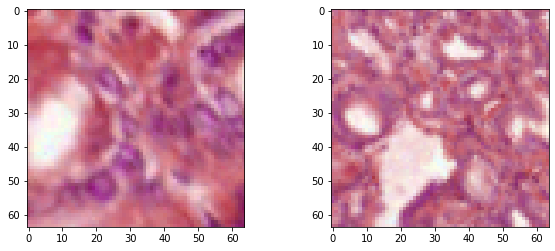

In [14]:
#visualize a single example to verify that it is correct
(imgres1,imgres2, label)=dataset["train"][0]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(imgres1.numpy(),0,-1))
ax[1].imshow(np.moveaxis(imgres2.numpy(),0,-1))


# ax[0].imshow(imgres1)
# ax[1].imshow(imgres2)


print(class_names[label])

In [15]:
optim = torch.optim.Adam(model.parameters(), weight_decay=.001) 

In [16]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class

class_weight=dataset["train"].classsizes
print(class_weight)
#class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)
class_weight = torch.from_numpy(class_weight.max()/class_weight).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 

[[ 7500 14500  6000  3000 14500  6000  5000]]
tensor([[1.9333, 1.0000, 2.4167, 4.8333, 1.0000, 2.4167, 2.9000]],
       device='cuda:0')


In [17]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (Xres1, Xres2, label) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            Xres1 = Xres1.to(device)  # [Nbatch, 3, H, W]
            Xres2 = Xres2.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...num_classes)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                
                prediction = model.dualfoward(Xres1,Xres2)  # [N, Nclass]
                #prediction = model.res1(Xres1)  # [N, Nclass]
                #prediction = model.res2(Xres2)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                            shape=(nclasses, nclasses), dtype=np.int64,
                            ).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM
                    

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if epoch in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}
        torch.save(state, f"{dataname}-best.pth")
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}
        torch.save(state, f"{dataname}-best.pth")
        torch.save(state, f"{dataname}-latest.pth")
            
    else:
        print("")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide



6m 41s (- 661m 52s) ([1/100] 1%), train loss: 1.6131 test loss: 1.3935  **



13m 26s (- 658m 15s) ([2/100] 2%), train loss: 1.2808 test loss: 1.3193  **



20m 13s (- 653m 29s) ([3/100] 3%), train loss: 1.1488 test loss: 1.8839



27m 0s (- 647m 56s) ([4/100] 4%), train loss: 1.0671 test loss: 1.0660  **



33m 44s (- 641m 0s) ([5/100] 5%), train loss: 1.0020 test loss: 1.4462



40m 29s (- 634m 16s) ([6/100] 6%), train loss: 0.9442 test loss: 1.0363  **



47m 15s (- 627m 47s) ([7/100] 7%), train loss: 0.8959 test loss: 1.5553



54m 2s (- 621m 25s) ([8/100] 8%), train loss: 0.8628 test loss: 0.8661  **



60m 51s (- 615m 20s) ([9/100] 9%), train loss: 0.8378 test loss: 1.3046



67m 38s (- 608m 42s) ([10/100] 10%), train loss: 0.8095 test loss: 0.8623  **



74m 26s (- 602m 15s) ([11/100] 11%), train loss: 0.7798 test loss: 0.8165  **



81m 14s (- 595m 46s) ([12/100] 12%), train loss: 0.7603 test loss: 0.7755  **



88m 4s (- 589m 24s) ([13/100] 13%), train loss: 0.7289 test loss: 0.7970



94m 47s (- 582m 12s) ([14/100] 14%), train loss: 0.7104 test loss: 1.2616



101m 31s (- 575m 13s) ([15/100] 15%), train loss: 0.6849 test loss: 1.1479



108m 16s (- 568m 25s) ([16/100] 16%), train loss: 0.6612 test loss: 0.9025



115m 5s (- 561m 53s) ([17/100] 17%), train loss: 0.6488 test loss: 0.6253  **



121m 55s (- 555m 22s) ([18/100] 18%), train loss: 0.6299 test loss: 1.1685



128m 42s (- 548m 39s) ([19/100] 19%), train loss: 0.6169 test loss: 0.8263



135m 28s (- 541m 53s) ([20/100] 20%), train loss: 0.6020 test loss: 0.7189



142m 11s (- 534m 54s) ([21/100] 21%), train loss: 0.5794 test loss: 0.6266



148m 54s (- 527m 54s) ([22/100] 22%), train loss: 0.5806 test loss: 0.9398



155m 37s (- 521m 0s) ([23/100] 23%), train loss: 0.5605 test loss: 0.6223  **



162m 20s (- 514m 2s) ([24/100] 24%), train loss: 0.5474 test loss: 0.5681  **



169m 2s (- 507m 5s) ([25/100] 25%), train loss: 0.5479 test loss: 0.5601  **



175m 46s (- 500m 14s) ([26/100] 26%), train loss: 0.5386 test loss: 0.6017



182m 28s (- 493m 21s) ([27/100] 27%), train loss: 0.5258 test loss: 0.5469  **



189m 16s (- 486m 41s) ([28/100] 28%), train loss: 0.5251 test loss: 0.5835



196m 1s (- 479m 54s) ([29/100] 28%), train loss: 0.5153 test loss: 0.6018



202m 44s (- 473m 1s) ([30/100] 30%), train loss: 0.5101 test loss: 0.9418



209m 31s (- 466m 21s) ([31/100] 31%), train loss: 0.5048 test loss: 0.5528



216m 18s (- 459m 38s) ([32/100] 32%), train loss: 0.4926 test loss: 0.6364



223m 0s (- 452m 46s) ([33/100] 33%), train loss: 0.4905 test loss: 0.4806  **



229m 47s (- 446m 2s) ([34/100] 34%), train loss: 0.4824 test loss: 0.5121



236m 33s (- 439m 18s) ([35/100] 35%), train loss: 0.4732 test loss: 0.4879



243m 20s (- 432m 34s) ([36/100] 36%), train loss: 0.4704 test loss: 0.8951



250m 7s (- 425m 52s) ([37/100] 37%), train loss: 0.4689 test loss: 0.5413



256m 53s (- 419m 7s) ([38/100] 38%), train loss: 0.4589 test loss: 0.5831



263m 40s (- 412m 24s) ([39/100] 39%), train loss: 0.4557 test loss: 0.7602



270m 28s (- 405m 42s) ([40/100] 40%), train loss: 0.4516 test loss: 0.5078



277m 15s (- 398m 57s) ([41/100] 41%), train loss: 0.4486 test loss: 0.4689  **



283m 58s (- 392m 8s) ([42/100] 42%), train loss: 0.4531 test loss: 0.6021



290m 41s (- 385m 18s) ([43/100] 43%), train loss: 0.4422 test loss: 0.4829



297m 29s (- 378m 36s) ([44/100] 44%), train loss: 0.4370 test loss: 0.5522



304m 18s (- 371m 55s) ([45/100] 45%), train loss: 0.4284 test loss: 0.4817



311m 3s (- 365m 8s) ([46/100] 46%), train loss: 0.4368 test loss: 0.6034



317m 47s (- 358m 21s) ([47/100] 47%), train loss: 0.4196 test loss: 0.5744



324m 32s (- 351m 34s) ([48/100] 48%), train loss: 0.4190 test loss: 0.4655  **



331m 18s (- 344m 49s) ([49/100] 49%), train loss: 0.4089 test loss: 0.5408



338m 5s (- 338m 5s) ([50/100] 50%), train loss: 0.4215 test loss: 0.4935



344m 52s (- 331m 20s) ([51/100] 51%), train loss: 0.4169 test loss: 0.5699



351m 36s (- 324m 32s) ([52/100] 52%), train loss: 0.4107 test loss: 0.6077



358m 19s (- 317m 44s) ([53/100] 53%), train loss: 0.4127 test loss: 0.4024  **



365m 4s (- 310m 58s) ([54/100] 54%), train loss: 0.4035 test loss: 0.4192



371m 47s (- 304m 10s) ([55/100] 55%), train loss: 0.4033 test loss: 0.4008  **



378m 31s (- 297m 24s) ([56/100] 56%), train loss: 0.4017 test loss: 0.4776



385m 18s (- 290m 39s) ([57/100] 56%), train loss: 0.4031 test loss: 0.4587



392m 3s (- 283m 53s) ([58/100] 57%), train loss: 0.4020 test loss: 0.3946  **



398m 45s (- 277m 5s) ([59/100] 59%), train loss: 0.4018 test loss: 0.5448



405m 29s (- 270m 19s) ([60/100] 60%), train loss: 0.3962 test loss: 0.6002



412m 13s (- 263m 32s) ([61/100] 61%), train loss: 0.3947 test loss: 0.4668



418m 58s (- 256m 47s) ([62/100] 62%), train loss: 0.3869 test loss: 0.4461



425m 47s (- 250m 3s) ([63/100] 63%), train loss: 0.3905 test loss: 0.5028



432m 33s (- 243m 18s) ([64/100] 64%), train loss: 0.3864 test loss: 0.4491



439m 18s (- 236m 32s) ([65/100] 65%), train loss: 0.3836 test loss: 0.3808  **



446m 5s (- 229m 47s) ([66/100] 66%), train loss: 0.3859 test loss: 0.4418



452m 48s (- 223m 0s) ([67/100] 67%), train loss: 0.3804 test loss: 0.3931



459m 27s (- 216m 12s) ([68/100] 68%), train loss: 0.3779 test loss: 0.4172



466m 9s (- 209m 25s) ([69/100] 69%), train loss: 0.3733 test loss: 0.4273



472m 52s (- 202m 39s) ([70/100] 70%), train loss: 0.3810 test loss: 0.7076



479m 33s (- 195m 52s) ([71/100] 71%), train loss: 0.3776 test loss: 0.6594



486m 21s (- 189m 7s) ([72/100] 72%), train loss: 0.3745 test loss: 0.4065



493m 6s (- 182m 22s) ([73/100] 73%), train loss: 0.3726 test loss: 0.8007



499m 51s (- 175m 37s) ([74/100] 74%), train loss: 0.3711 test loss: 0.4074



506m 33s (- 168m 50s) ([75/100] 75%), train loss: 0.3742 test loss: 0.3921



513m 16s (- 162m 4s) ([76/100] 76%), train loss: 0.3675 test loss: 0.4698



520m 0s (- 155m 19s) ([77/100] 77%), train loss: 0.3688 test loss: 0.7284



526m 42s (- 148m 32s) ([78/100] 78%), train loss: 0.3659 test loss: 0.3863



533m 27s (- 141m 47s) ([79/100] 79%), train loss: 0.3665 test loss: 0.4386



540m 15s (- 135m 3s) ([80/100] 80%), train loss: 0.3637 test loss: 0.5663



547m 1s (- 128m 18s) ([81/100] 81%), train loss: 0.3646 test loss: 0.3721  **



553m 48s (- 121m 33s) ([82/100] 82%), train loss: 0.3614 test loss: 0.6331



560m 37s (- 114m 49s) ([83/100] 83%), train loss: 0.3616 test loss: 0.4463



567m 22s (- 108m 3s) ([84/100] 84%), train loss: 0.3652 test loss: 0.4464



574m 3s (- 101m 17s) ([85/100] 85%), train loss: 0.3557 test loss: 0.4213



580m 46s (- 94m 32s) ([86/100] 86%), train loss: 0.3563 test loss: 0.5385



587m 29s (- 87m 46s) ([87/100] 87%), train loss: 0.3568 test loss: 0.4763



594m 11s (- 81m 1s) ([88/100] 88%), train loss: 0.3559 test loss: 0.3979



600m 57s (- 74m 16s) ([89/100] 89%), train loss: 0.3561 test loss: 0.4482



607m 39s (- 67m 30s) ([90/100] 90%), train loss: 0.3545 test loss: 0.7407



614m 19s (- 60m 45s) ([91/100] 91%), train loss: 0.3578 test loss: 0.4020



621m 3s (- 53m 59s) ([92/100] 92%), train loss: 0.3506 test loss: 0.4348



627m 45s (- 47m 14s) ([93/100] 93%), train loss: 0.3470 test loss: 0.3415  **



634m 30s (- 40m 29s) ([94/100] 94%), train loss: 0.3506 test loss: 1.1320



641m 19s (- 33m 44s) ([95/100] 95%), train loss: 0.3487 test loss: 0.3514



648m 4s (- 26m 59s) ([96/100] 96%), train loss: 0.3480 test loss: 0.3450



654m 48s (- 20m 14s) ([97/100] 97%), train loss: 0.3481 test loss: 0.4724



661m 35s (- 13m 29s) ([98/100] 98%), train loss: 0.3464 test loss: 0.3465



668m 19s (- 6m 44s) ([99/100] 99%), train loss: 0.3487 test loss: 0.3629



675m 1s (- -1m 59s) ([100/100] 100%), train loss: 0.3482 test loss: 0.3977


In [23]:
cmatrix

{'train': array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 'val': array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])}

In [17]:
Xres2

tensor([[[[0.7137, 0.7020, 0.7647,  ..., 0.6784, 0.6588, 0.6314],
          [0.7412, 0.7098, 0.7176,  ..., 0.6353, 0.6157, 0.6275],
          [0.7804, 0.7137, 0.7059,  ..., 0.7020, 0.6392, 0.6745],
          ...,
          [0.8275, 0.7961, 0.7843,  ..., 0.6392, 0.7137, 0.7647],
          [0.8392, 0.7647, 0.6824,  ..., 0.6039, 0.6706, 0.7098],
          [0.7608, 0.7333, 0.6667,  ..., 0.6588, 0.6863, 0.6627]],

         [[0.3020, 0.3373, 0.4667,  ..., 0.1569, 0.1647, 0.1725],
          [0.4039, 0.4157, 0.4118,  ..., 0.1765, 0.1412, 0.2275],
          [0.4902, 0.4039, 0.3412,  ..., 0.4235, 0.2706, 0.3725],
          ...,
          [0.6235, 0.5569, 0.5725,  ..., 0.2275, 0.3333, 0.4157],
          [0.6157, 0.5098, 0.3412,  ..., 0.2039, 0.2588, 0.2863],
          [0.4431, 0.3765, 0.2392,  ..., 0.2980, 0.3333, 0.2157]],

         [[0.4627, 0.4863, 0.6078,  ..., 0.3451, 0.3490, 0.3569],
          [0.5490, 0.5569, 0.5569,  ..., 0.3608, 0.3294, 0.4039],
          [0.6314, 0.5333, 0.4941,  ..., 0